In [ ]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline 

# Hide warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df = pd.read_csv('result_cc_lcl_1.csv')
df['FSCL_WK_END_DT'] = pd.to_datetime(df['FSCL_WK_END_DT'])
df['year'] = df['FSCL_WK_END_DT'].dt.year
df['month'] = df['FSCL_WK_END_DT'].dt.month
df

,FSCL_WK_END_DT,BASECODE,DIV_TDP,SELLING_STR_CNT_IN_DIV,STORE_COUNT_IN_DIV,DELIVERY_QUANTITY_LBS,HLDY_INCLUDED_IN_WEEK_FLAG,year,month
0,2017-01-14,681000111700,0.961819,919,1073,16799.560,0,2017,1
1,2017-01-14,681000112500,0.997151,991,1073,51589.200,0,2017,1
2,2017-01-14,681000145500,0.666798,753,1073,6575.475,0,2017,1
3,2017-01-14,681000145900,0.544287,612,1073,7566.300,0,2017,1
4,2017-01-14,681000146500,0.311126,309,1073,2792.325,0,2017,1
...,...,...,...,...,...,...,...,...,...
6827,2021-03-27,681008965000,0.922285,865,1073,7926.600,0,2021,3
6828,2021-03-27,681008965100,0.893768,809,1073,7920.595,0,2021,3
6829,2021-03-27,681009006400,0.436437,312,1073,944.370,0,2021,3
6830,2021-03-27,681009013200,0.802403,714,1073,2111.280,0,2021,3


In [ ]:
df.columns

Index(['FSCL_WK_END_DT', 'BASECODE', 'DIV_TDP', 'SELLING_STR_CNT_IN_DIV',
       'STORE_COUNT_IN_DIV', 'DELIVERY_QUANTITY_LBS',
       'HLDY_INCLUDED_IN_WEEK_FLAG', 'year', 'month'],
      dtype='object')

In [ ]:
new_df = df[['FSCL_WK_END_DT', 'BASECODE', 'DIV_TDP','SELLING_STR_CNT_IN_DIV','STORE_COUNT_IN_DIV','DELIVERY_QUANTITY_LBS','HLDY_INCLUDED_IN_WEEK_FLAG', 'year', 'month']]
new_df.columns = ['fscl_wk_end_dt', 'basecode', 'div_tdp','selling_str_cnt_in_div','store_count_in_div','delivery_quantity_lbs','hldy_included_in_week_flag', 'year', 'month']
new_df.fillna(0)
new_df.drop_duplicates(inplace=True)
new_df.set_index('fscl_wk_end_dt', inplace = True)
new_df

,basecode,div_tdp,selling_str_cnt_in_div,store_count_in_div,delivery_quantity_lbs,hldy_included_in_week_flag,year,month
fscl_wk_end_dt,,,,,,,,
2017-01-14,681000111700,0.961819,919,1073,16799.560,0,2017,1
2017-01-14,681000112500,0.997151,991,1073,51589.200,0,2017,1
2017-01-14,681000145500,0.666798,753,1073,6575.475,0,2017,1
2017-01-14,681000145900,0.544287,612,1073,7566.300,0,2017,1
2017-01-14,681000146500,0.311126,309,1073,2792.325,0,2017,1
...,...,...,...,...,...,...,...,...
2021-03-27,681008965000,0.922285,865,1073,7926.600,0,2021,3
2021-03-27,681008965100,0.893768,809,1073,7920.595,0,2021,3
2021-03-27,681009006400,0.436437,312,1073,944.370,0,2021,3


In [ ]:
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

In [ ]:
agg_delivery_lb_df = new_df.groupby(by='fscl_wk_end_dt').delivery_quantity_lbs.sum().to_frame()

,delivery_quantity_lbs
fscl_wk_end_dt,
2017-01-14,160931.995
2017-01-21,148346.010
2017-01-28,79049.445
2017-02-04,26635.240
2017-02-11,36615.580
...,...
2021-02-27,213585.428
2021-03-06,284770.809
2021-03-13,246371.176


<Figure size 432x288 with 0 Axes>

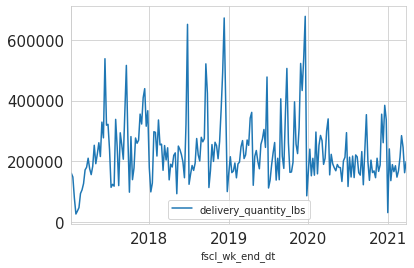

In [ ]:
fig = plt.figure()
#fig.suptitle('Delivery pounds over fiscal weeks')
#new_df[['delivery_quantity_lbs']].plot()
agg_delivery_lb_df.plot()
#new_df.plot(kind='scatter',x='fscl_wk_end_dt',y='delivery_quantity_lbs',color='red')
#new_df.plot(kind='line',x='basecode',y='delivery_quantity_lbs',ax=ax)
#new_df.plot(kind='line',x='fscl_wk_end_dt',y='delivery_quantity_lbs', color='red', ax=ax)
plt.show()

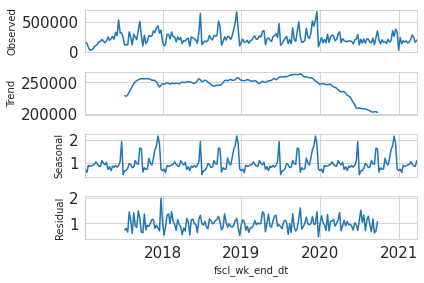

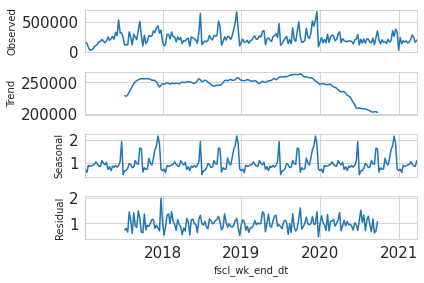

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative_ts_components = seasonal_decompose(agg_delivery_lb_df['delivery_quantity_lbs'], model='multiplicative',extrapolate_trend='freq')
multiplicative_ts_components.plot()

In [ ]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
agg_delivery_lb_df_multiplicative_reconstructed = pd.concat([multiplicative_ts_components.seasonal, multiplicative_ts_components.trend, multiplicative_ts_components.resid, multiplicative_ts_components.observed], axis=1)
agg_delivery_lb_df_multiplicative_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
agg_delivery_lb_df_multiplicative_reconstructed

,seas,trend,resid,actual_values
fscl_wk_end_dt,,,,
2017-01-14,0.743727,NaN,NaN,160931.995
2017-01-21,0.594707,NaN,NaN,148346.010
2017-01-28,0.905080,NaN,NaN,79049.445
2017-02-04,0.863453,NaN,NaN,26635.240
2017-02-11,0.889493,NaN,NaN,36615.580
...,...,...,...,...
2021-02-27,1.064563,NaN,NaN,213585.428
2021-03-06,0.953522,NaN,NaN,284770.809
2021-03-13,0.879756,NaN,NaN,246371.176


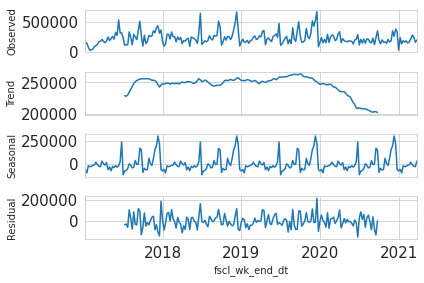

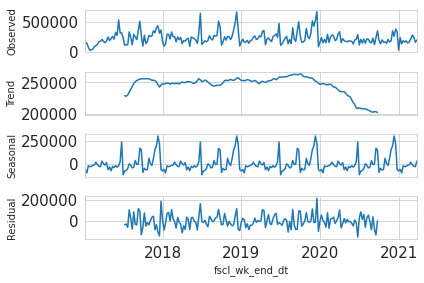

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
additive_ts_components = seasonal_decompose(agg_delivery_lb_df['delivery_quantity_lbs'], model='additive',extrapolate_trend='freq')
additive_ts_components.plot()

In [ ]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
agg_delivery_lb_df_additive_reconstructed = pd.concat([additive_ts_components.seasonal, additive_ts_components.trend, additive_ts_components.resid, additive_ts_components.observed], axis=1)
agg_delivery_lb_df_additive_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
agg_delivery_lb_df_additive_reconstructed

,seas,trend,resid,actual_values
fscl_wk_end_dt,,,,
2017-01-14,-63921.493607,NaN,NaN,160931.995
2017-01-21,-101283.049498,NaN,NaN,148346.010
2017-01-28,-24447.934373,NaN,NaN,79049.445
2017-02-04,-34536.242248,NaN,NaN,26635.240
2017-02-11,-28732.150335,NaN,NaN,36615.580
...,...,...,...,...
2021-02-27,15274.064261,NaN,NaN,213585.428
2021-03-06,-12147.062248,NaN,NaN,284770.809
2021-03-13,-30020.235745,NaN,NaN,246371.176


In [ ]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
multiplicative_ts_components.plot().suptitle('Multiplicative Decompose', fontsize=22)
additive_ts_components.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
result = adfuller(agg_delivery_lb_df['delivery_quantity_lbs'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(agg_delivery_lb_df['delivery_quantity_lbs'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.824747713098095
p-value: 5.223757213149737e-17
Critial Values:
   1%, -3.460567372610299
Critial Values:
   5%, -2.874829809033386
Critial Values:
   10%, -2.573853225954421

KPSS Statistic: 0.146439
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
